In [ ]:
!pip uninstall scikit-learn --yes
!pip uninstall imblearn --yes
!pip install scikit-learn==1.2.2
!pip install imblearn
!pip install scikeras

In [19]:
import pandas as pd
import time
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df = df.drop("id",axis=1)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [20]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [21]:
missing_values = df.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]

(columns_with_missing_values)

bmi    201
dtype: int64

In [22]:
# for column in df.columns[:5]:
#   df[column] = df[column].astype("category")

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [24]:
from imblearn.over_sampling import SMOTE

In [25]:
y = df["stroke"]
X = df.drop("stroke",axis=1)

In [26]:
y.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [27]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin


class LogTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['log_mileage'] = np.log1p(X['mileage'])
        return X

In [29]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64','float64']).columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
    #('poly', PolynomialFeatures())
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(drop='first')),
])

preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features),
    ],
    remainder='passthrough',
)

pipe = Pipeline([
    ('regressor', DummyRegressor(strategy='mean')),
])

In [30]:
from sklearn.model_selection import train_test_split
X_ = preprocessing_pipeline.fit_transform(X)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_, y)
y_resampled.value_counts()


stroke
1    4861
0    4861
Name: count, dtype: int64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
)

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

def build_nn_model():
    # creating the layers of the NN
  model = Sequential()
  model.add(Dense(48*3, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dense(8*1, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# Define the parameter grid
param_grid = [
    {
        'regressor': [XGBClassifier()],
        'regressor__n_estimators': [50, 75, 100],
        'regressor__max_depth': [1, 5, 10, 15],
    },
    {
        'regressor': [KerasClassifier(build_fn=build_nn_model, verbose=0)],
        'regressor__batch_size': [8,16, 32],
        'regressor__epochs': [5,50, 100]
    }
]

num_splits = 10
test_fraction = 0.2
num_samples_total = len(y_train)
num_samples_test = int(test_fraction * num_samples_total)
num_samples_train = num_samples_total - num_samples_test

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=ShuffleSplit(
        n_splits=num_splits,
        test_size=num_samples_test,
        random_state=42,
    ),
    n_jobs=-1,
    scoring="roc_auc",
    verbose=1
)

grid.fit(X_train, y_train)


Fitting 10 folds for each of 21 candidates, totalling 210 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=1555, train_size=None),
             estimator=Pipeline(steps=[('regressor', DummyRegressor())]),
             n_jobs=-1,
             param_grid=[{'regressor': [XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      en...
                                                      multi_strategy=None,
                                                      n_estimators=75,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...)],
                          'regressor__max_depth': [1, 5, 10, 15],
                          'regressor__n_estimators': [50, 75, 100]},
                         {'regressor': [KerasClassifier(build_fn=<function build_nn_model at 0x786df9f35360>, verbose=0)],
                          'regressor__batch_size': [None, 16, 32],
                          'regressor__epochs': [None, 50, 100]}],
             scoring='roc_auc', verbose=1)

In [33]:
import re
def extract_estimator_name(index):
    if "XGBClassifier" in index:
        parts = index.split("(", 1)
        if len(parts) > 1:
            prefix = parts[0] + "()"
        else:
            prefix = parts[0]
        return (prefix + parts[1].split("...)")[-1])
    elif "KerasClassifier" in index:
      classifier_name = re.match(r'(.+?)\(', index).group(1) + "()"
      trailing_numbers_match = re.search(r'\)_([\d_]+)$', index)
      trailing_numbers = trailing_numbers_match.group(1) if trailing_numbers_match else ""

      return  classifier_name + "_" + trailing_numbers
    else:
        return index


In [34]:
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("model")
results_df.index = results_df.index.map(extract_estimator_name)
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
model,,,,
XGBClassifier()_10_75,"{'regressor': XGBClassifier(base_score=None, b...",1,0.991851,0.001372
XGBClassifier()_10_50,"{'regressor': XGBClassifier(base_score=None, b...",2,0.991770,0.001467
XGBClassifier()_10_100,"{'regressor': XGBClassifier(base_score=None, b...",3,0.991717,0.001382
XGBClassifier()_15_75,"{'regressor': XGBClassifier(base_score=None, b...",4,0.991694,0.001284
XGBClassifier()_15_50,"{'regressor': XGBClassifier(base_score=None, b...",5,0.991623,0.001315
XGBClassifier()_15_100,"{'regressor': XGBClassifier(base_score=None, b...",6,0.991560,0.001234
XGBClassifier()_5_100,"{'regressor': XGBClassifier(base_score=None, b...",7,0.989316,0.002441
XGBClassifier()_5_75,"{'regressor': XGBClassifier(base_score=None, b...",8,0.988621,0.002615
XGBClassifier()_5_50,"{'regressor': XGBClassifier(base_score=None, b...",9,0.987029,0.002643


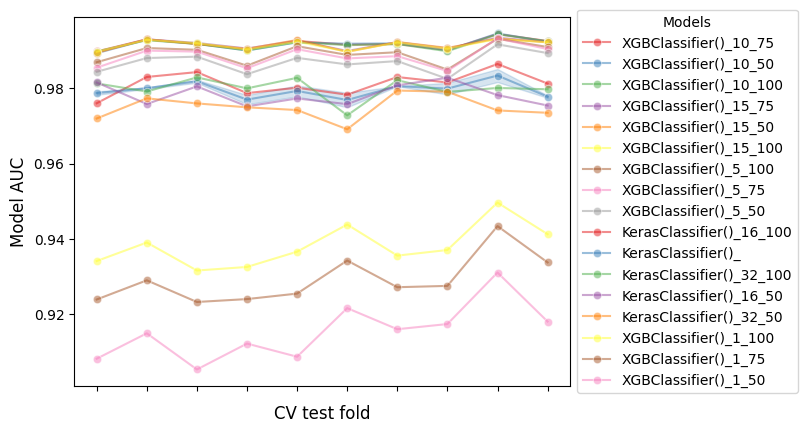

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_df is defined and contains the relevant data
model_scores = results_df.filter(regex=r"split\d*_test_score")

# Plot 30 examples of dependency between CV fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)

# Move legend outside of plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1.0, 0.5), title='Models')

ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)

plt.show()

# Print correlation of AUC scores across folds



In [36]:
print(f"Correlation of models:\n {model_scores.transpose().corr()}")

Correlation of models:
 model                     XGBClassifier()_10_75  XGBClassifier()_10_50  \
model                                                                    
XGBClassifier()_10_75                  1.000000               0.990449   
XGBClassifier()_10_50                  0.990449               1.000000   
XGBClassifier()_10_100                 0.996919               0.989672   
XGBClassifier()_15_75                  0.884061               0.852201   
XGBClassifier()_15_50                  0.844581               0.808327   
XGBClassifier()_15_100                 0.866960               0.831988   
XGBClassifier()_5_100                  0.948162               0.924084   
XGBClassifier()_5_75                   0.972172               0.952488   
XGBClassifier()_5_50                   0.941490               0.925391   
KerasClassifier()_16_100               0.737931               0.765857   
KerasClassifier()_                     0.539102               0.555835   
KerasClassifie

In [37]:
import numpy as np
from scipy.stats import t


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [38]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

differences = model_1_scores - model_2_scores

n = differences.shape[0]  # number of test sets
dof = n - 1

t_stat, p_val = compute_corrected_ttest(
    differences,
    dof,
    num_samples_train,
    num_samples_test,
)
print(f"Corrected t-statistic: {t_stat:.3f}")
print(f"Corrected p-value: {p_val:.3f}")

Corrected t-statistic: 0.591
Corrected p-value: 0.284


In [39]:
# Test all models against the best model.
best_model_scores = model_scores.iloc[0].values

n_comparisons = model_scores.shape[0] - 1

pairwise_t_test = []

for model_i in range(1, len(model_scores)):
    model_i_scores = model_scores.iloc[model_i].values
    differences = model_i_scores - best_model_scores
    t_stat, p_val = compute_corrected_ttest(
        differences,
        dof,
        num_samples_train,
        num_samples_test,
    )

    # Implement Bonferroni correction
    p_val *= n_comparisons

    # Bonferroni can output p-values higher than 1
    p_val = 1 if p_val > 1 else p_val

    pairwise_t_test.append([
        model_scores.index[0],
        model_scores.index[model_i],
        t_stat,
        p_val,
    ])

pairwise_comp_df = pd.DataFrame(
    pairwise_t_test,
    columns=["model_1", "model_2", "t_stat", "p_val"],
).round(3)

In [40]:
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,XGBClassifier()_10_75,XGBClassifier()_10_50,-0.591,1.000
1,XGBClassifier()_10_75,XGBClassifier()_10_100,-1.980,0.791
2,XGBClassifier()_10_75,XGBClassifier()_15_75,-0.389,1.000
3,XGBClassifier()_10_75,XGBClassifier()_15_50,-0.487,1.000
4,XGBClassifier()_10_75,XGBClassifier()_15_100,-0.680,1.000
5,XGBClassifier()_10_75,XGBClassifier()_5_100,-3.328,0.088
6,XGBClassifier()_10_75,XGBClassifier()_5_75,-3.919,0.035
7,XGBClassifier()_10_75,XGBClassifier()_5_50,-5.412,0.004
8,XGBClassifier()_10_75,KerasClassifier()_16_100,-7.897,0.000
9,XGBClassifier()_10_75,KerasClassifier()_,-7.551,0.000


In [ ]:
for model_i in range(1, len(model_scores)):
    model_i_scores = model_scores.iloc[model_i].values
    differences = model_i_scores - best_model_scores

    name_i = model_scores.index[model_i]
    name_best = model_scores.index[0]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(model_i_scores, bins=30, alpha=0.5, label=name_i)
    plt.hist(best_model_scores, bins=30, alpha=0.5, label=name_best)
    plt.title(f'{name_i} vs {name_best}')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.hist(differences, bins=30, alpha=0.5)
    plt.title(f'differences {name_i} - {name_best}')
    plt.show()